In [1]:
import utils as ut

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
def load_meteo(base_meteo, var):
    files = glob.glob(base_meteo + f'{var}_d/'+ f'{var}_d_ECEarth3_h*_per_country.nc')
    files.sort()
    datasets = []
    for f in files:
        dset = xr.open_dataset(f)
        datasets.append(dset[var].where(dset['time'].dt.month.isin([11, 12, 1, 2, 3]), drop=True))
    data = xr.concat(datasets, dim='run')
    data['run'] = data['run'] + 10
    return data

In [3]:
METEO_PATH = '/net/pc200256/nobackup/users/most/LENTIS/per_country/present/day/'
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
VARIABLE = 'residual'

data_tas = load_meteo(METEO_PATH, 'tas').drop('height')
data_sfcwind = load_meteo(METEO_PATH, 'sfcWind').drop('height')
data_rsds = load_meteo(METEO_PATH, 'rsds')
ds = xr.merge([data_tas.rename('tas'), data_sfcwind.rename('sfcWind'), data_rsds.rename('rsds')])

In [8]:
#TODO: get netto_demand (ignoring reservoir hydropower)
xr.open_dataset(ENERGY_PATH + 'NLD_LENTIS_PD_02_v4.nc')

<xarray.DataArray 'residual' (country: 1, runs: 160, time: 3591)>
[574560 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01T12:00:00 ... 2009-11-30T12:00:00
  * runs     (runs) object 'h010' 'h011' 'h012' 'h013' ... 'h167' 'h168' 'h169'
  * country  (country) float64 29.0
Attributes:
    standard_name:  residual load
    long_name:      total demand minus total renewable energy production
    units:          MWh

In [4]:
# also load energy data
energy_data = ut.load_data(ENERGY_PATH, VARIABLE, stacked = False)
energy_data = energy_data.rename({'runs': 'run'})
energy_data['run'] = np.arange(10, 170)

In [5]:
country_mapping = {
    1.0: 'AUT',
    4.0: 'BEL',
    5.0: 'BGR',
    3.0: 'BIH',
    6.0: 'CHE',
    7.0: 'CYP',
    8.0: 'CZE',
    9.0: 'DEU',
    10.0: 'DNK',
    13.0: 'ESP',
    11.0: 'EST',
    14.0: 'FIN',
    15.0: 'FRA',
    39.0: 'GBR',
    12.0: 'GRC',
    16.0: 'HRV',
    17.0: 'HUN',
    18.0: 'IRL',
    20.0: 'ITA',
    22.0: 'LTU',
    24.0: 'LVA',
    27.0: 'MKD',
    26.0: 'MNE',
    29.0: 'NLD',
    30.0: 'NOR',
    31.0: 'POL',
    32.0: 'PRT',
    33.0: 'ROU',
    34.0: 'SRB',
    37.0: 'SVK',
    36.0: 'SVN',
    35.0: 'SWE',
    2.0: 'UKR'
}

### Prepare dataframes

In [6]:
data_stacked = ds.stack(event=('run', 'time'))
data_ranked = data_stacked.compute().rank(dim='event', pct=True)
energy_stacked = energy_data.stack(event=('run', 'time'))
energy_ranked = energy_stacked.compute().rank(dim='event', pct=True)

In [7]:
df_energy = energy_ranked.reset_index(['country', 'run', 'time']).to_dataframe().reset_index(['country', 'event']).drop(columns = ['event'])

In [8]:
df_meteo = data_ranked.reset_index(['run', 'time']).to_dataframe().reset_index(['country', 'event']).drop(columns = ['event', 'height'])
df_meteo['country_name'] = df_meteo['country'].map(country_mapping)
df_meteo.dropna(subset=['country_name'], inplace=True)
column_order = ['country', 'country_name', 'run', 'time', 'tas', 'sfcWind', 'rsds']
df_meteo = df_meteo[column_order]

In [9]:
df = df_meteo.merge(df_energy, on=['country_name', 'run', 'time']).drop(columns = ['country_x', 'country_y'])

In [10]:
def calc_median_std_event(country_name, thres, results):
    df_extreme = df.query('country_name == @country_name and residual > @thres')
    median_values = df_extreme[['tas', 'sfcWind', 'rsds']].median()
    std_values = df_extreme[['tas', 'sfcWind', 'rsds']].std()
    results[country_name] = {'median': median_values, 'std': std_values}


### Analysis

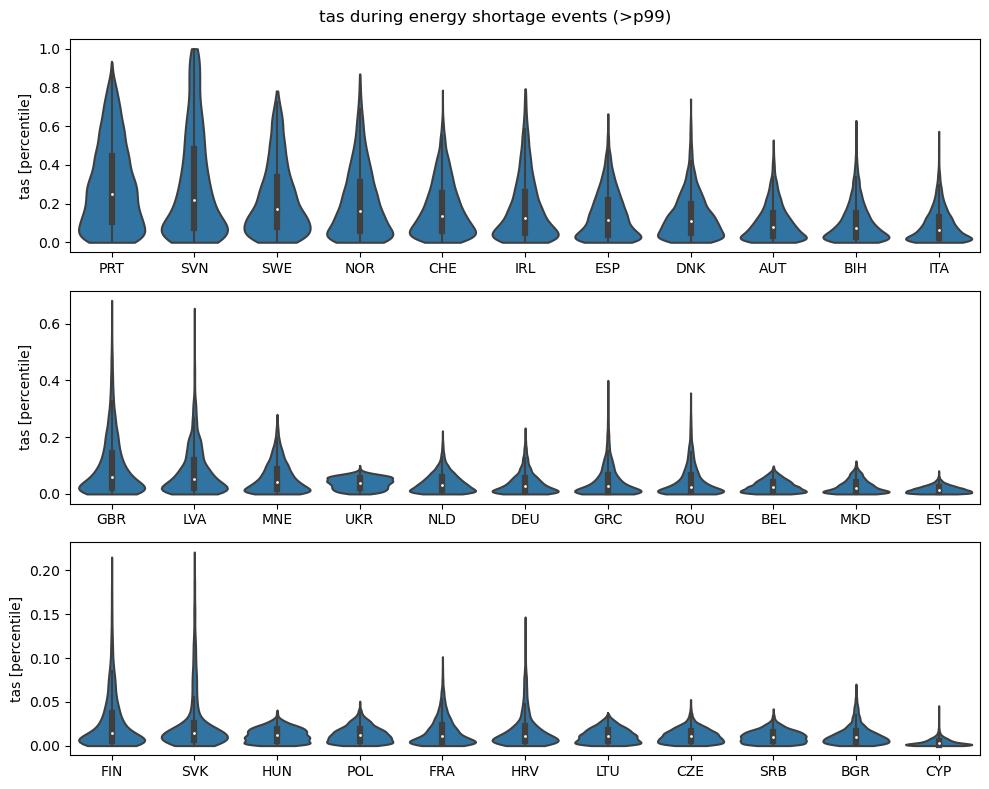

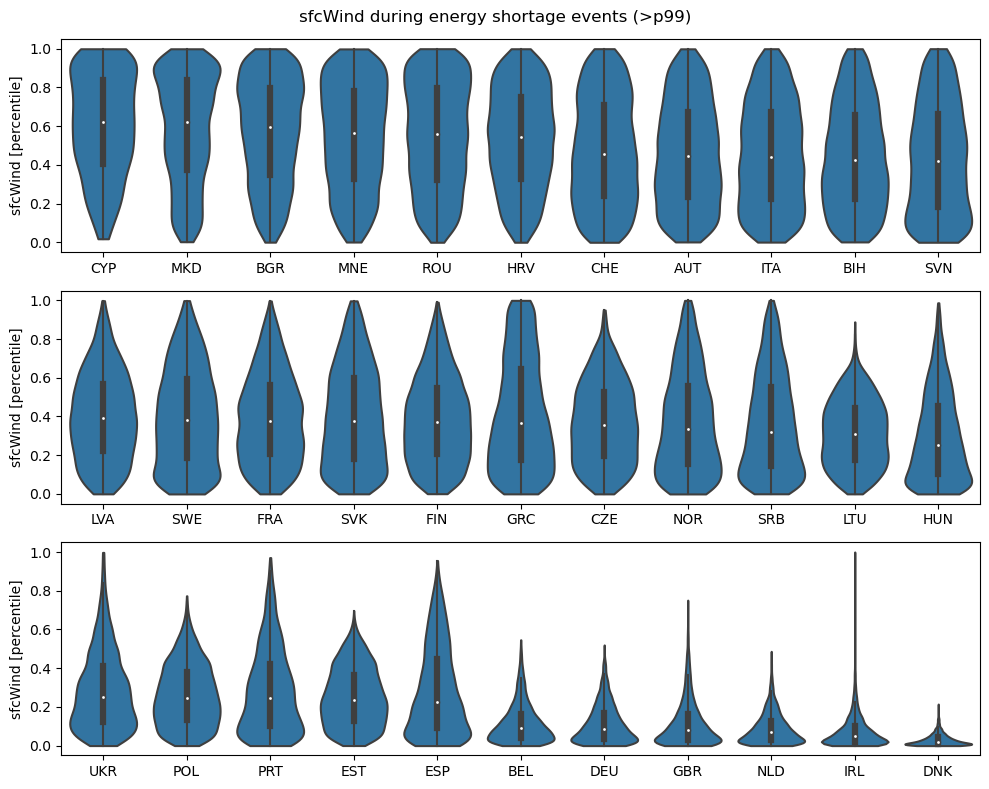

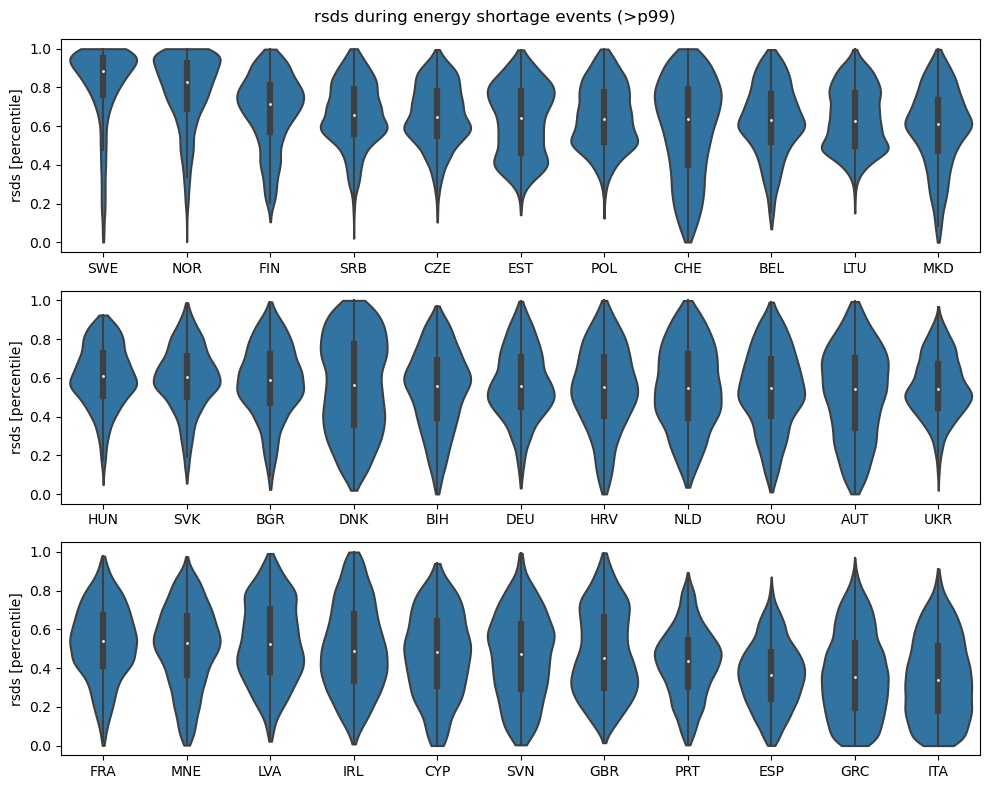

In [11]:
variables = ['tas', 'sfcWind', 'rsds']
thres = 0.99

country_results = {}

for country_name in country_mapping.values():
    calc_median_std_event(country_name, thres, country_results)

df_extreme = df.query('residual > @thres')
countries_per_plot = 11

for variable in variables:
    variable_data = [(country, country_results[country]['median'][variable]) for country in country_results]

    sorted_data = sorted(variable_data, key=lambda x: x[1], reverse=True)

    sorted_countries, sorted_medians = zip(*sorted_data)

    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    for i in range(3):
        selected_countries = sorted_countries[i * countries_per_plot: (i + 1) * countries_per_plot]

        sns.violinplot(data=df_extreme[df_extreme["country_name"].isin(selected_countries)],
                    x="country_name", y=variable, color='C0', cut=0, order=selected_countries, scale="width", ax=axes[i])
        
        axes[i].set_ylabel(f'{variable} [percentile]')
        axes[i].set_xlabel('')

    plt.suptitle(f'{variable} during energy shortage events (>p99)')
    plt.tight_layout()

### Trying to combine multiple meteo percentiles

(array([9.507e+03, 6.130e+02, 1.870e+02, 6.100e+01, 3.500e+01, 2.200e+01,
        7.000e+00, 9.000e+00, 1.100e+01, 1.400e+01]),
 array([4.13086583e-06, 9.95968275e-02, 1.99189524e-01, 2.98782221e-01,
        3.98374917e-01, 4.97967614e-01, 5.97560311e-01, 6.97153007e-01,
        7.96745704e-01, 8.96338401e-01, 9.95931097e-01]),
 <BarContainer object of 10 artists>)

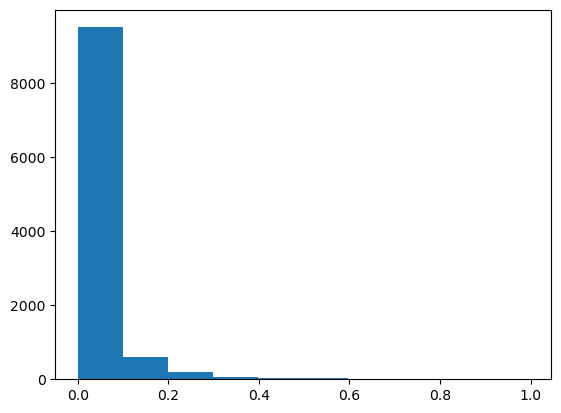

In [77]:
thres_energy = 0.999
thres_compound = 0.10
df_extreme = df.query('residual > @thres_energy')
plt.hist(df_extreme['tas'])

(array([3082., 1704., 1117.,  978.,  854.,  774.,  618.,  555.,  448.,
         336.]),
 array([4.13086583e-06, 9.99723232e-02, 1.99940516e-01, 2.99908708e-01,
        3.99876900e-01, 4.99845093e-01, 5.99813285e-01, 6.99781477e-01,
        7.99749670e-01, 8.99717862e-01, 9.99686054e-01]),
 <BarContainer object of 10 artists>)

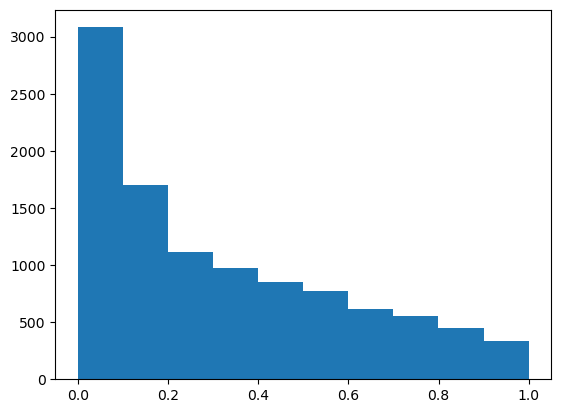

In [78]:
plt.hist(df_extreme['sfcWind'])

Text(0, 0.5, 'Wind speed')

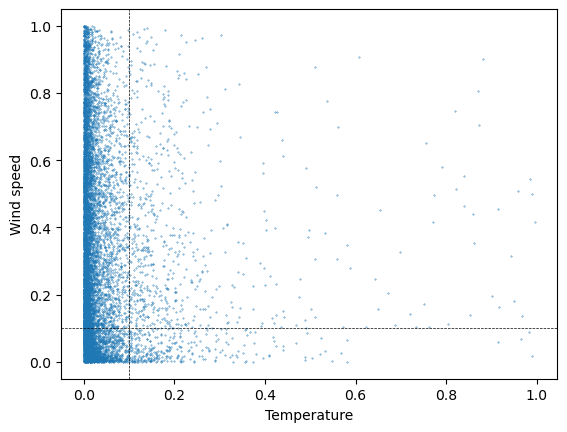

In [79]:
plt.scatter(df_extreme['tas'], df_extreme['sfcWind'], s = 0.1)
plt.axhline(thres_compound, color='black', linestyle = '--', lw=0.5)
plt.axvline(thres_compound, color='black', linestyle = '--', lw=0.5)
plt.xlabel('Temperature')
plt.ylabel('Wind speed')

In [80]:
high_t = df_extreme.query('tas > @thres_compound').groupby('country_name').size()
all = df_extreme.groupby('country_name').size()
(high_t / all).sort_values(ascending = False)

country_name
PRT    0.660606
SVN    0.542857
CHE    0.412121
IRL    0.272727
SWE    0.260062
AUT    0.204819
NOR    0.170213
ESP    0.157100
GBR    0.106061
LVA    0.078550
DNK    0.066667
ITA    0.042296
BIH    0.033333
ROU    0.006079
SVK    0.006061
BEL         NaN
BGR         NaN
CYP         NaN
CZE         NaN
DEU         NaN
EST         NaN
FIN         NaN
FRA         NaN
GRC         NaN
HRV         NaN
HUN         NaN
LTU         NaN
MKD         NaN
MNE         NaN
NLD         NaN
POL         NaN
SRB         NaN
UKR         NaN
dtype: float64

Text(0, 0.5, 'Wind speed')

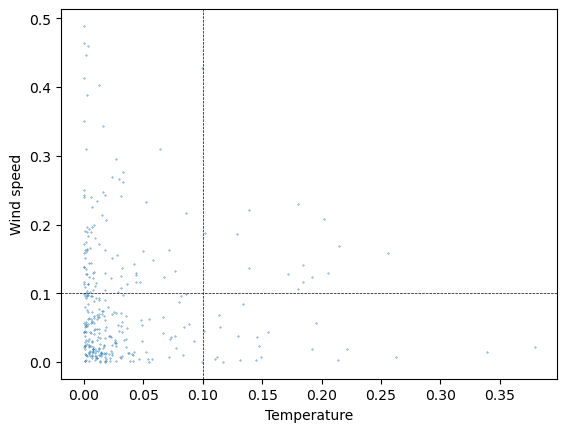

In [83]:
country = "GBR"
df_extreme_country = df_extreme.query('country_name == @country')
plt.scatter(df_extreme_country['tas'], df_extreme_country['sfcWind'], s = 0.1)
plt.axhline(thres_compound, color='black', linestyle = '--', lw=0.5)
plt.axvline(thres_compound, color='black', linestyle = '--', lw=0.5)
plt.xlabel('Temperature')
plt.ylabel('Wind speed')

In [82]:
df_extreme.query('country_name == "GBR" and tas > @thres_compound')

,country_name,run,time,tas,sfcWind,rsds,residual,mean_meteo
7449865,GBR,24,2003-01-09 12:00:00,0.180031,0.230337,0.380825,0.999002,0.263731
7462216,GBR,32,2007-12-27 12:00:00,0.131366,0.003528,0.311261,0.999181,0.148718
7500457,GBR,59,2001-11-28 12:00:00,0.116808,0.000004,0.393816,0.999903,0.170210
7500458,GBR,59,2001-11-29 12:00:00,0.192127,0.018143,0.290784,0.999245,0.167018
7514299,GBR,68,2006-12-25 12:00:00,0.262975,0.007345,0.111079,0.999151,0.127133
7521707,GBR,73,2007-12-27 12:00:00,0.139173,0.221278,0.220287,0.999484,0.193579
7521708,GBR,73,2007-12-28 12:00:00,0.215028,0.168130,0.254812,0.999130,0.212657
7527374,GBR,77,2007-01-10 12:00:00,0.179771,0.106254,0.497377,0.999563,0.261134
7529960,GBR,79,2004-12-27 12:00:00,0.214041,0.002487,0.133877,0.999412,0.116802
7529961,GBR,79,2004-12-28 12:00:00,0.154862,0.043721,0.138301,0.999272,0.112295


In [60]:
df.query('country_name == "GBR" and run == 10 and time > "2005-11-25 12:00:00" and time < "2005-12-10 12:00:00"')

,country_name,run,time,tas,sfcWind,rsds,residual,mean_meteo
7429961,GBR,10,2005-11-26 12:00:00,0.406977,0.023517,0.470485,0.847092,0.300326
7429962,GBR,10,2005-11-27 12:00:00,0.379544,0.041994,0.421332,0.917986,0.280957
7429963,GBR,10,2005-11-28 12:00:00,0.404106,0.054304,0.354639,0.956729,0.271016
7429964,GBR,10,2005-11-29 12:00:00,0.227247,0.008960,0.433919,0.995018,0.223375
7429965,GBR,10,2005-11-30 12:00:00,0.193093,0.050083,0.365499,0.992476,0.202892
7429966,GBR,10,2005-12-01 12:00:00,0.273178,0.205610,0.423649,0.979315,0.300812
7429967,GBR,10,2005-12-02 12:00:00,0.252371,0.343242,0.347612,0.992874,0.314408
7429968,GBR,10,2005-12-03 12:00:00,0.351442,0.650492,0.180552,0.720991,0.394162
7429969,GBR,10,2005-12-04 12:00:00,0.430271,0.680461,0.308505,0.552338,0.473079
7429970,GBR,10,2005-12-05 12:00:00,0.257795,0.228924,0.308675,0.888349,0.265131


Text(0, 0.5, 'Wind speed')

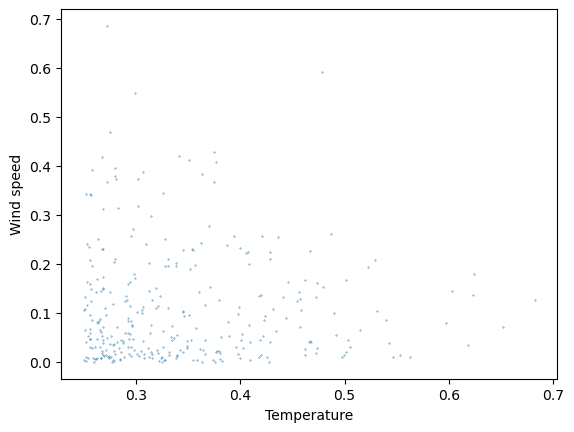

In [44]:
UK_compound = df_extreme.query('country_name == "GBR" and tas > 0.25')
plt.scatter(UK_compound['tas'], UK_compound['sfcWind'], s = 0.1)
plt.xlabel('Temperature')
plt.ylabel('Wind speed')

In [62]:
df_extreme.query('country_name == "NLD" and tas > 0.15')

,country_name,run,time,tas,sfcWind,rsds,residual
5353760,NLD,19,2006-12-25 12:00:00,0.161984,0.012339,0.144692,0.992231
5355315,NLD,20,2007-11-08 12:00:00,0.209782,0.006944,0.615838,0.991285
5356201,NLD,21,2003-12-18 12:00:00,0.162397,0.061971,0.405172,0.990041
5358244,NLD,22,2007-12-05 12:00:00,0.157940,0.003024,0.209303,0.992455
5374592,NLD,34,2000-11-29 12:00:00,0.222418,0.000074,0.379734,0.991482
5378243,NLD,36,2005-11-22 12:00:00,0.163297,0.035360,0.549124,0.990420
5379250,NLD,37,2002-12-02 12:00:00,0.183448,0.020741,0.231899,0.990781
5379418,NLD,37,2003-12-19 12:00:00,0.176235,0.051739,0.373476,0.991633
5399554,NLD,51,2002-11-22 12:00:00,0.172315,0.041705,0.175901,0.991042
5401615,NLD,52,2006-11-27 12:00:00,0.181861,0.017407,0.141210,0.991291


### Appendix

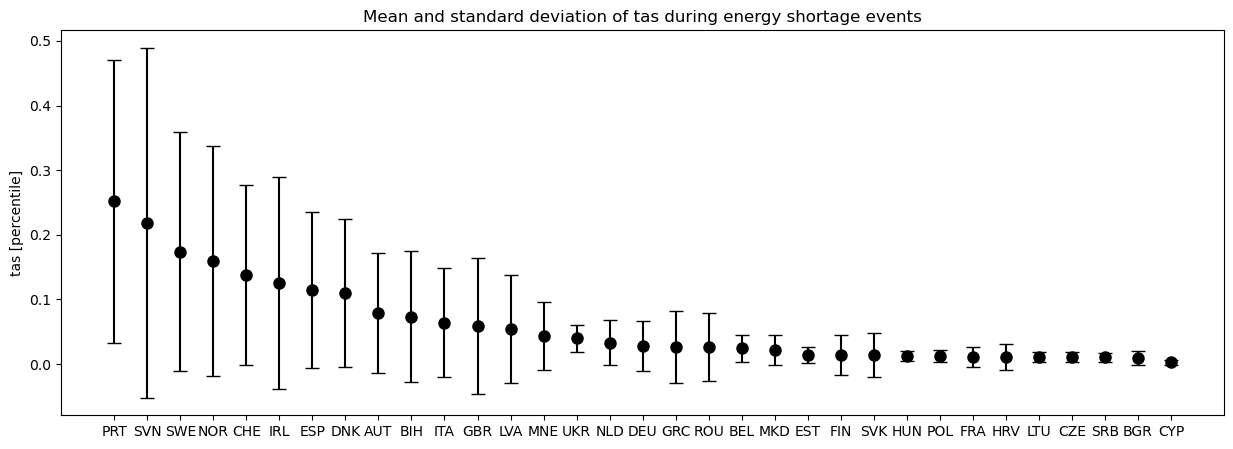

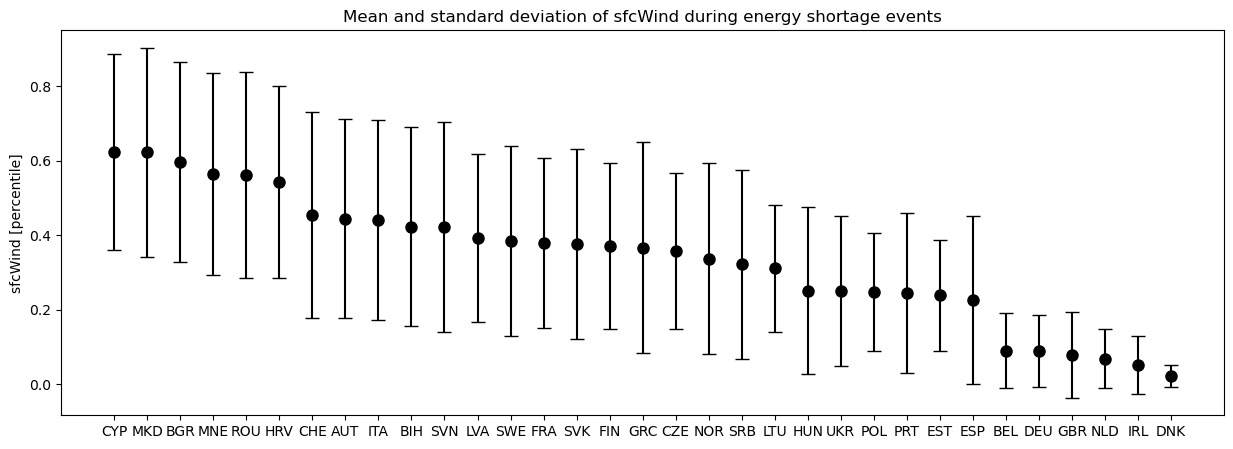

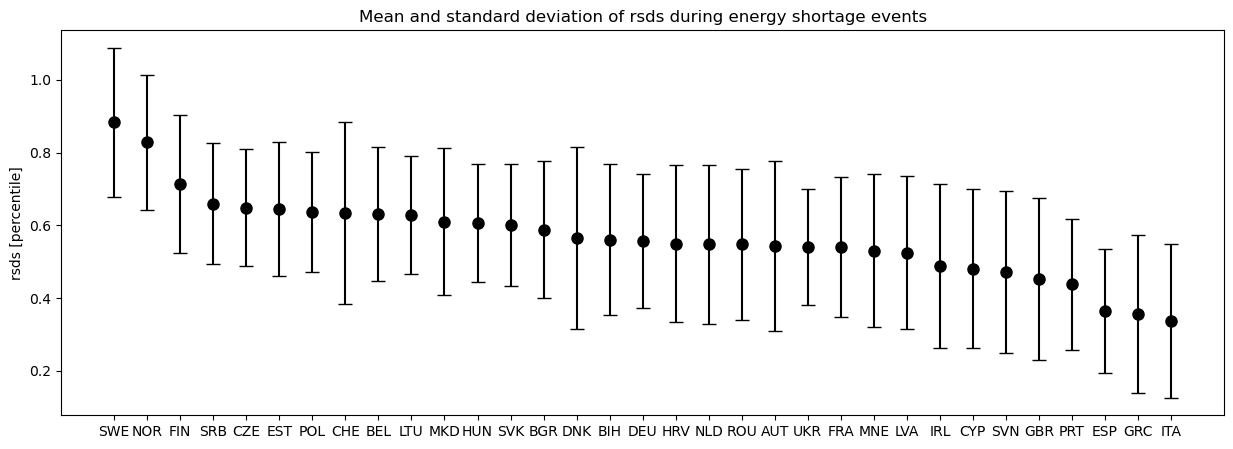

In [12]:
variables = ['tas', 'sfcWind', 'rsds']

for variable in variables:
    variable_data = [(country, country_results[country]['median'][variable], country_results[country]['std'][variable]) for country in country_results]

    sorted_data = sorted(variable_data, key=lambda x: x[1], reverse=True)

    sorted_countries, sorted_medians, sorted_stds = zip(*sorted_data)

    plt.figure(figsize = (15, 5))
    plt.errorbar(sorted_countries, sorted_medians, yerr=sorted_stds, fmt='o', capsize=5, markersize=8, color='k')
    plt.title(f'Mean and standard deviation of {variable} during energy shortage events')
    plt.ylabel(f'{variable} [percentile]')